# Capstone Project: Modeling Stroke Risk

This notebook presents the modeling phase of the Heart Stroke Prediction Capstone Project. The primary objective is to develop predictive models that can accurately identify individuals at risk of stroke using clinical and demographic data.


## 1. Setup and Imports

In this section, we import the required libraries and load the preprocessed datasets for modeling.


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import os
import joblib

In [8]:
# 1. Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Load Processed Data
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv').values.ravel()
y_test = pd.read_csv('y_test.csv').values.ravel()


## 2. Baseline Model Training

We begin by training three classifiers with class weights adjusted to compensate for the class imbalance:
- Logistic Regression
- Random Forest
- Support Vector Machine


In [10]:
# Logistic Regression Pipeline
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Random Forest Pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Optional for trees, but kept for consistency
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# SVM Pipeline
svc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(probability=True, class_weight='balanced'))
])


## 3. Model Evaluation

We define an evaluation function that displays the classification report and confusion matrix for each model.


In [11]:
def evaluate_model(name, y_test, y_pred):
    print(f"\nModel: {name}")
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


## 4. Evaluate Models

This section evaluates baseline models using metrics such as accuracy, recall, precision, and F1-score, with a focus on class 1 (stroke).



Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1458
           1       0.13      0.76      0.22        75

    accuracy                           0.74      1533
   macro avg       0.56      0.75      0.53      1533
weighted avg       0.94      0.74      0.81      1533



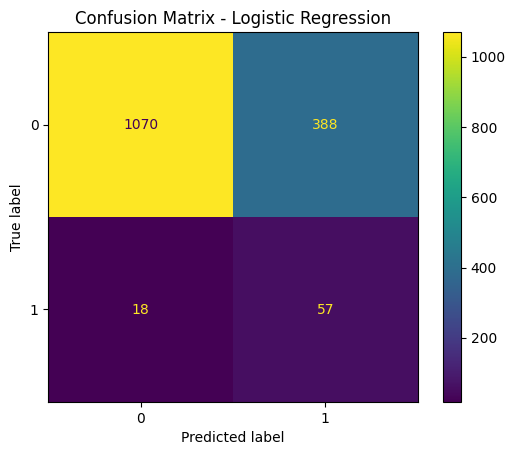


Model: Random Forest
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1458
           1       0.14      0.31      0.19        75

    accuracy                           0.87      1533
   macro avg       0.55      0.60      0.56      1533
weighted avg       0.92      0.87      0.89      1533



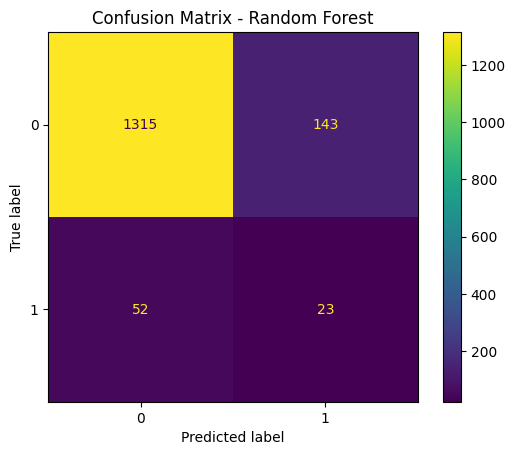


Model: Support Vector Machine
              precision    recall  f1-score   support

           0       0.98      0.71      0.83      1458
           1       0.11      0.71      0.19        75

    accuracy                           0.71      1533
   macro avg       0.55      0.71      0.51      1533
weighted avg       0.94      0.71      0.79      1533



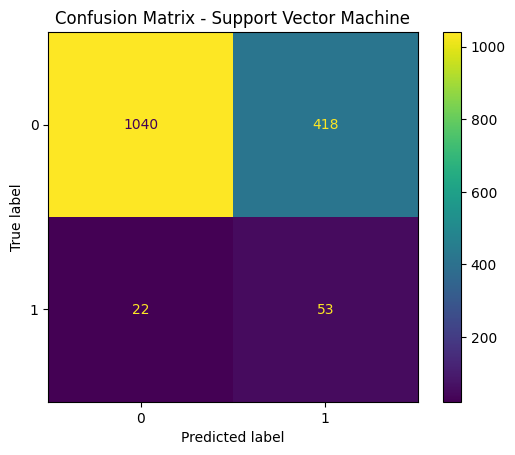

In [12]:
# Fit pipelines
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

svc_pipeline.fit(X_train, y_train)
y_pred_svc = svc_pipeline.predict(X_test)

# Evaluate
evaluate_model("Logistic Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("Support Vector Machine", y_test, y_pred_svc)


## 5. Hyperparameter Tuning - Random Forest

We use GridSearchCV to tune key hyperparameters of the Random Forest model.


Best Params (Random Forest): {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}

Model: Random Forest (Tuned Pipeline)
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1458
           1       0.14      0.32      0.20        75

    accuracy                           0.87      1533
   macro avg       0.55      0.61      0.57      1533
weighted avg       0.92      0.87      0.90      1533



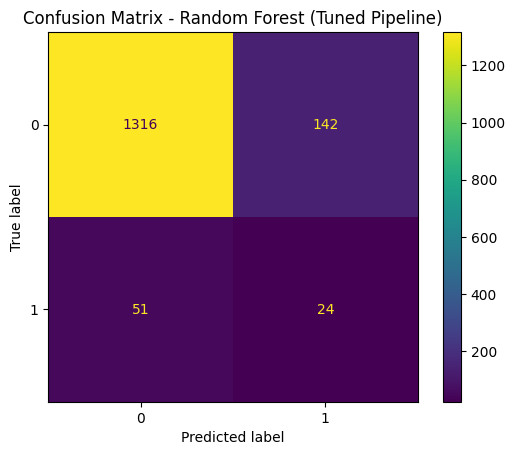

In [14]:
param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='f1')
grid_rf.fit(X_train, y_train)

print("Best Params (Random Forest):", grid_rf.best_params_)

y_pred_rf_tuned = grid_rf.predict(X_test)
evaluate_model("Random Forest (Tuned Pipeline)", y_test, y_pred_rf_tuned)


## 6. Hyperparameter Tuning - SVM

We fine-tune the Support Vector Machine model using a parameter grid that includes the `C` value, kernel type, and gamma.


Best Params (SVM): {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}

Model: SVM (Tuned Pipeline)
              precision    recall  f1-score   support

           0       0.97      0.74      0.84      1458
           1       0.11      0.60      0.18        75

    accuracy                           0.73      1533
   macro avg       0.54      0.67      0.51      1533
weighted avg       0.93      0.73      0.81      1533



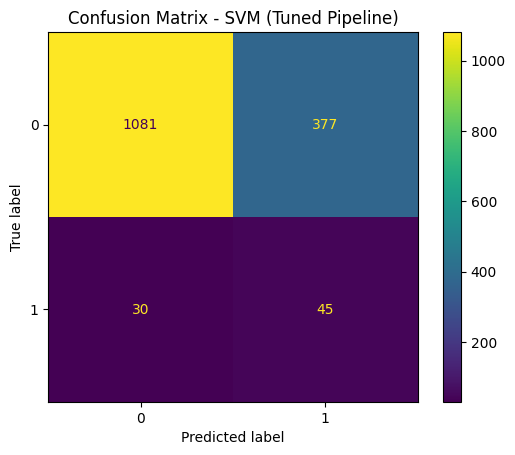

In [15]:
param_grid_svc = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma': ['scale', 'auto']
}

grid_svc = GridSearchCV(svc_pipeline, param_grid_svc, cv=5, scoring='f1')
grid_svc.fit(X_train, y_train)

print("Best Params (SVM):", grid_svc.best_params_)

y_pred_svc_tuned = grid_svc.predict(X_test)
evaluate_model("SVM (Tuned Pipeline)", y_test, y_pred_svc_tuned)


## 7. Model Selection

We compare the models using the ROC AUC score and choose the best-performing model based on recall and F1-score.


## ROC AUC COMPARISON

In [16]:
auc_rf = roc_auc_score(y_test, grid_rf.predict_proba(X_test)[:, 1])
auc_svc = roc_auc_score(y_test, grid_svc.predict_proba(X_test)[:, 1])
auc_lr = roc_auc_score(y_test, lr_pipeline.predict_proba(X_test)[:, 1])

print("\nROC AUC Scores:")
print(f"Logistic Regression: {auc_lr:.3f}")
print(f"Random Forest (Tuned): {auc_rf:.3f}")
print(f"SVM (Tuned): {auc_svc:.3f}")



ROC AUC Scores:
Logistic Regression: 0.833
Random Forest (Tuned): 0.799
SVM (Tuned): 0.750


## FINAL MODEL RANDOM FOREST

In [21]:
# Create models folder if it doesn’t exist
os.makedirs('models', exist_ok=True)

# Save best estimator from Random Forest pipeline
joblib.dump(grid_rf.best_estimator_, 'models/random_forest_pipeline.pkl')
print("Model saved to models/random_forest_pipeline.pkl")


Model saved to models/random_forest_pipeline.pkl


## 8. SHAP Explainability

SHAP (SHapley Additive exPlanations) helps interpret feature importance in the selected model, offering insights into what drives the stroke predictions.


100%|===================| 13599/13612 [13:53<00:00]        

<Figure size 640x480 with 0 Axes>

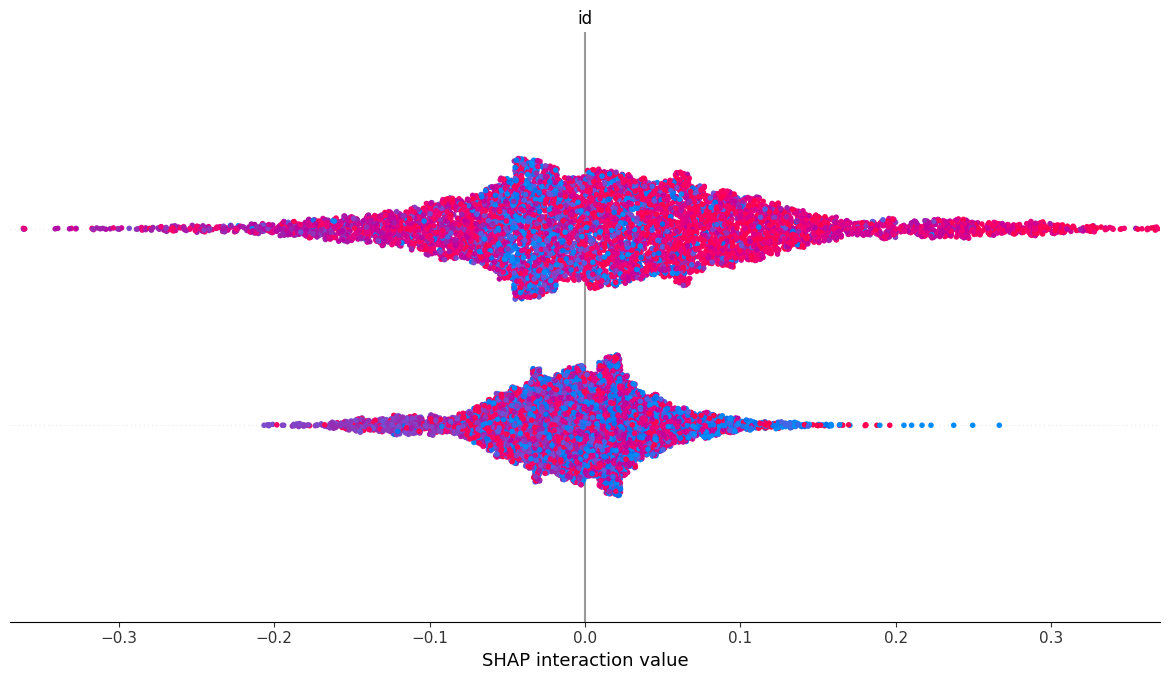

In [22]:
import shap

explainer = shap.Explainer(grid_rf.best_estimator_['clf'], X_train)
shap_values = explainer(X_train, check_additivity=False)`

shap.summary_plot(shap_values, X_train, plot_type="bar")


 ## 9. Learning Curve Analysis

We analyze how the model learns as the training size increases to detect underfitting or overfitting patterns.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 90, in _c

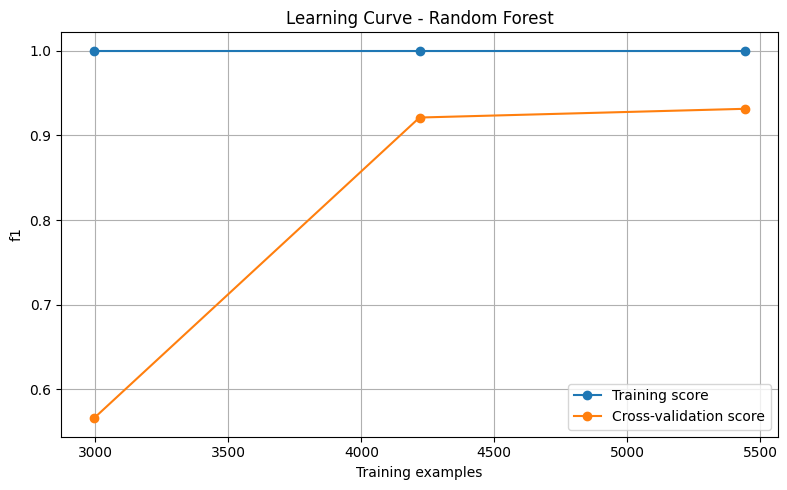

In [23]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=None, scoring='f1', n_jobs=-1):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=np.linspace(0.1, 1.0, 5)
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    plt.grid()
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

plot_learning_curve(grid_rf.best_estimator_, "Learning Curve - Random Forest", X_train, y_train, cv=5, scoring='f1')
